In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

tf.random.set_seed(42)
np.random.seed(42)

igneous_rock_properties = {
    "Halite":      {"velocity": (1.6, 0.1), "amplitude": (0.26, 0.01), "duration": (140, 5), "frequency_Hz": (14, 2)},
    "Sylvite":     {"velocity": (1.7, 0.1), "amplitude": (0.27, 0.01), "duration": (150, 5), "frequency_Hz": (16, 2)},
    "Trona":       {"velocity": (1.8, 0.1), "amplitude": (0.29, 0.01), "duration": (145, 5), "frequency_Hz": (17, 2)},
    "Borax":       {"velocity": (1.7, 0.1), "amplitude": (0.28, 0.01), "duration": (150, 5), "frequency_Hz": (15, 2)},
}

def generate_dataset(props, samples_per_class=800, seed=42):
    """Generate dataset with more samples for better training"""
    np.random.seed(seed)
    data = []

    for rock_type, features in props.items():
        for _ in range(samples_per_class):
            row = {
                "rock_type": rock_type,
                "velocity": np.random.normal(*features["velocity"]),
                "amplitude": np.random.normal(*features["amplitude"]),
                "duration": np.random.normal(*features["duration"]),
                "frequency_Hz": np.random.normal(*features["frequency_Hz"])
            }
            data.append(row)

    df = pd.DataFrame(data)
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    return df

df = generate_dataset(igneous_rock_properties)

df['velocity_x_amplitude'] = df['velocity'] * df['amplitude']
df['velocity_squared'] = df['velocity'] ** 2
df['duration_squared'] = df['duration'] ** 2
df['amplitude_duration'] = df['amplitude'] * df['duration']
df['velocity_frequency'] = df['velocity'] * df['frequency_Hz']
df['amplitude_frequency'] = df['amplitude'] * df['frequency_Hz']
df['duration_frequency'] = df['duration'] * df['frequency_Hz']
df['velocity_duration'] = df['velocity'] * df['duration']
df['amplitude_squared'] = df['amplitude'] ** 2
df['frequency_squared'] = df['frequency_Hz'] ** 2
df['velocity_amplitude_ratio'] = df['velocity'] / df['amplitude']
df['duration_frequency_ratio'] = df['duration'] / df['frequency_Hz']
df['velocity_duration_ratio'] = df['velocity'] / df['duration']
df['velocity_cubed'] = df['velocity'] ** 3
df['amplitude_cubed'] = df['amplitude'] ** 3

print(df)

     rock_type  velocity  amplitude    duration  frequency_Hz  \
0        Trona  1.720179   0.300185  138.552500     16.396840   
1        Borax  1.654301   0.265918  150.385393     17.111388   
2        Trona  1.974431   0.296636  146.023989     17.818282   
3      Sylvite  1.823958   0.266038  155.341897     17.208242   
4       Halite  1.516764   0.264714  137.238885     15.265864   
...        ...       ...        ...         ...           ...   
3195   Sylvite  1.715713   0.271762  146.665756     16.395833   
3196   Sylvite  1.651229   0.280743  152.482001     20.150130   
3197   Sylvite  1.569841   0.251470  149.375566     16.031396   
3198   Sylvite  1.714552   0.263859  150.704913     19.177254   
3199     Borax  1.842326   0.278666  143.067553     13.952314   

      velocity_x_amplitude  velocity_squared  duration_squared  \
0                 0.516373          2.959017      19196.795160   
1                 0.439908          2.736711      22615.766445   
2                 0.5

In [2]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['rock_type'])
feature_cols = [
    'velocity', 'amplitude', 'duration', 'frequency_Hz',
    'velocity_x_amplitude', 'velocity_squared', 'duration_squared',
    'amplitude_duration', 'velocity_frequency', 'amplitude_frequency',
    'duration_frequency', 'velocity_duration', 'amplitude_squared',
    'frequency_squared', 'velocity_amplitude_ratio', 'duration_frequency_ratio',
    'velocity_duration_ratio', 'velocity_cubed', 'amplitude_cubed'
]

X = df[feature_cols].values
y = df['label'].values

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [3]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(enumerate(class_weights))

def create_model(input_dim, num_classes, dropout_rate=0.3):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),

        # First block
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),

        # Second block
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),

        # Third block
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate * 0.5),

        # Fourth block
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate * 0.5),

        # Output layer
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = create_model(X_scaled.shape[1], len(le.classes_))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [4]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=20,
        restore_best_weights=True,
        monitor='val_accuracy',
        min_delta=0.001
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.3,
        patience=8,
        min_lr=1e-6,
        monitor='val_accuracy',
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "Evaporites and Soft Minerals_model.keras",
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    )
]

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,820 (729.77 KB)

 Trainable params: 184,900 (722.27 KB)

 Non-trainable params: 1,920 (7.50 KB)

In [5]:
print("Training improved model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=150,  # More epochs with early stopping
    batch_size=64,  # Larger batch size for stability
    callbacks=callbacks,
    class_weight=class_weights_dict,
    verbose=1
)

Training improved model...
Epoch 1/150
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5585 - loss: 1.7821
Epoch 1: val_accuracy improved from -inf to 0.62813, saving model to Evaporites and Soft Minerals_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5658 - loss: 1.7622 - val_accuracy: 0.6281 - val_loss: 1.6932 - learning_rate: 0.0010
Epoch 2/150
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6720 - loss: 1.4287
Epoch 2: val_accuracy did not improve from 0.62813
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6723 - loss: 1.4281 - val_accuracy: 0.5547 - val_loss: 1.6826 - learning_rate: 0.0010
Epoch 3/150
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6705 - loss: 1.3704
Epoch 3: val_accuracy did not improve from 0.62813
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6710 - loss: 1.3699 - val_accuracy: 0.5656 - val_loss: 1.6507 - learning_rate: 0.0010
Epoch 4/150
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6812 - loss: 1.3351
E

In [6]:
model = tf.keras.models.load_model("Evaporites and Soft Minerals_model.keras")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

accuracy = np.mean(y_pred == y_test)
print(f"\nFinal Test Accuracy: {accuracy:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Classification Report:
              precision    recall  f1-score   support

       Borax       0.63      0.52      0.57       160
      Halite       0.88      0.86      0.87       160
     Sylvite       0.62      0.80      0.70       160
       Trona       0.82      0.74      0.78       160

    accuracy                           0.73       640
   macro avg       0.74      0.73      0.73       640
weighted avg       0.74      0.73      0.73       640


Final Test Accuracy: 0.7297


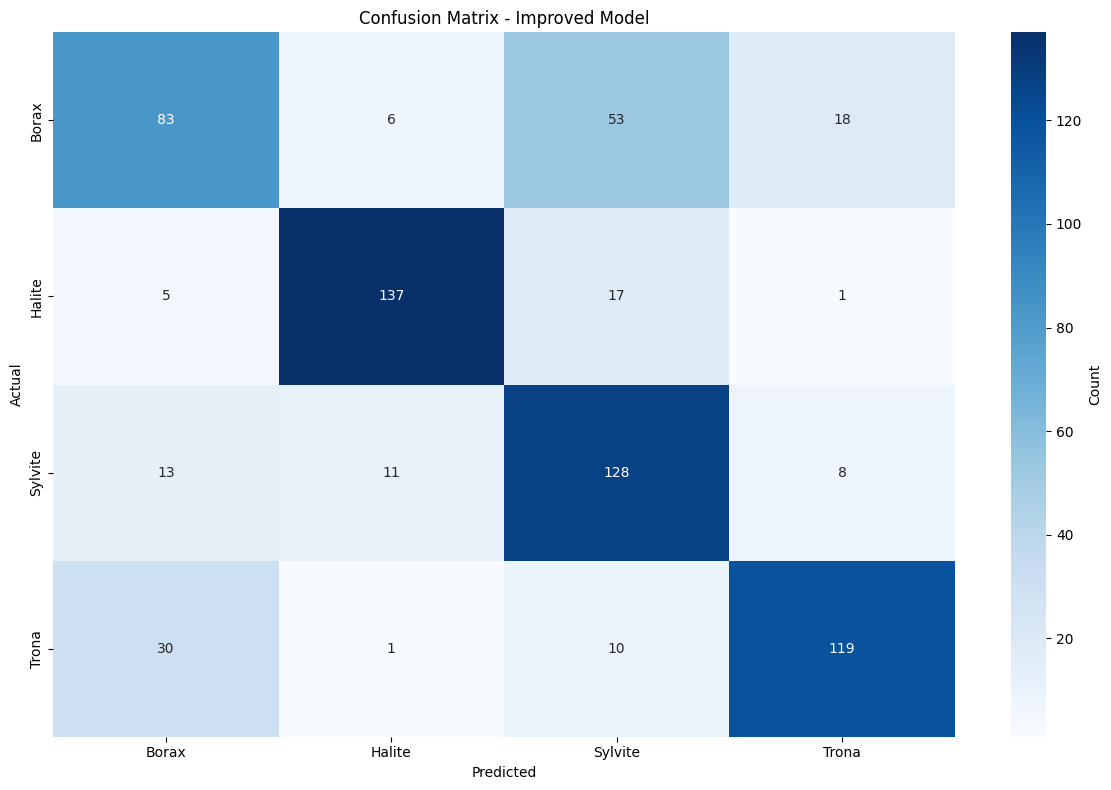

In [7]:
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_,
            cmap='Blues', cbar_kws={'label': 'Count'})
plt.title("Confusion Matrix - Improved Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

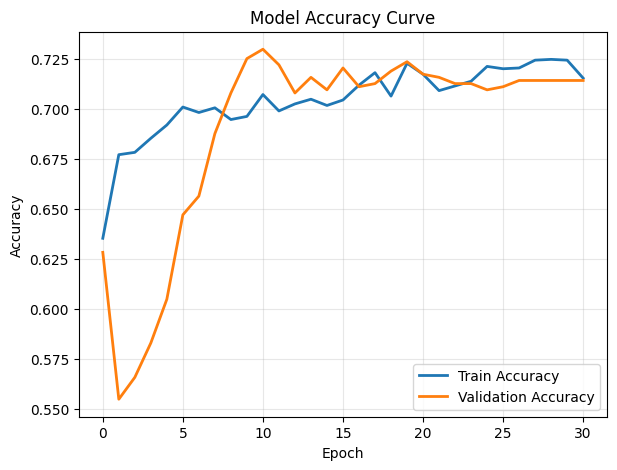

In [8]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title("Model Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

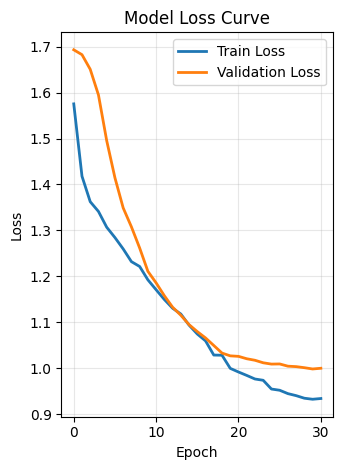

In [9]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title("Model Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Calculating feature importance...


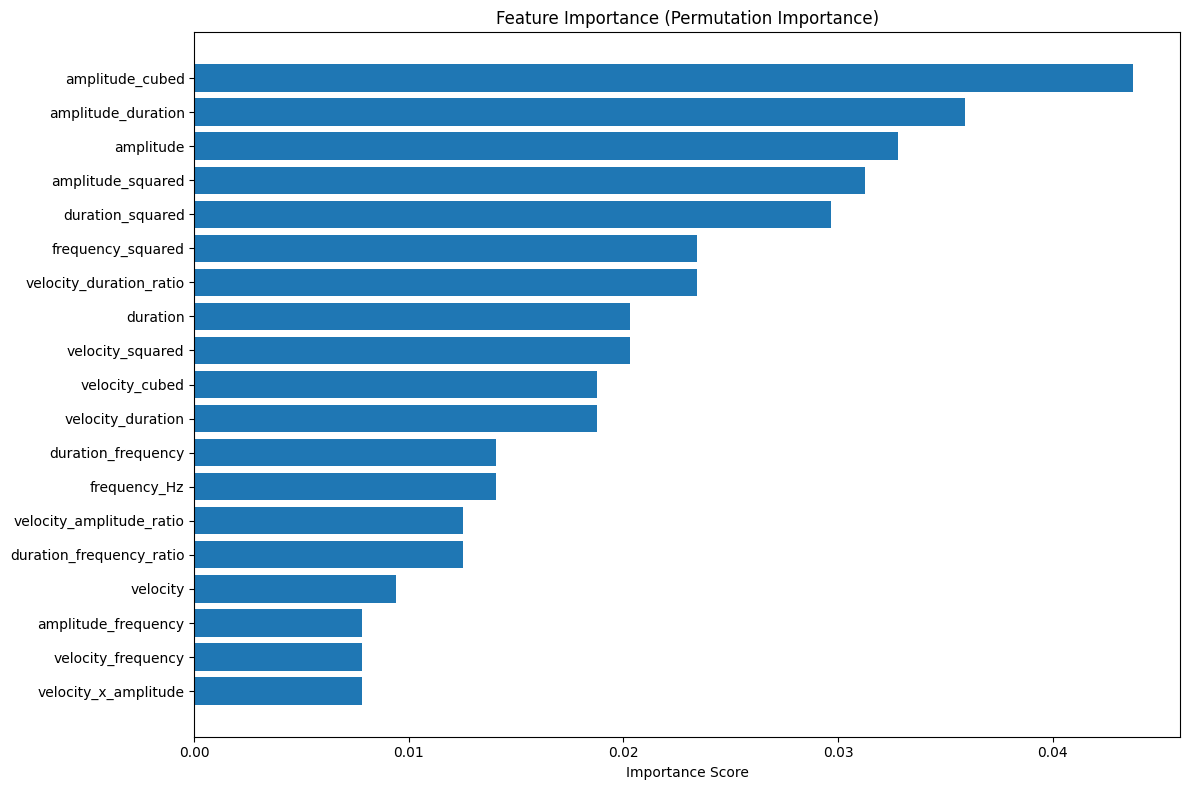

In [10]:
def get_feature_importance(model, X_test, feature_names):
    """Calculate feature importance using permutation importance"""
    baseline_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    importance_scores = []
    for i, feature in enumerate(feature_names):
        X_test_permuted = X_test.copy()
        np.random.shuffle(X_test_permuted[:, i])
        permuted_accuracy = model.evaluate(X_test_permuted, y_test, verbose=0)[1]
        importance = baseline_accuracy - permuted_accuracy
        importance_scores.append(importance)
    return importance_scores
print("\nCalculating feature importance...")
importance_scores = get_feature_importance(model, X_test, feature_cols)
plt.figure(figsize=(12, 8))
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importance_scores
}).sort_values('importance', ascending=True)

plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.title('Feature Importance (Permutation Importance)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [11]:
joblib.dump(scaler, "Evaporites and Soft Minerals_scaler.pkl")
joblib.dump(le, "Evaporites and Soft Minerals_label_encoder.pkl")
print(f"\nModel saved as: Evaporites and Soft Minerals_model.keras")
print(f"Scaler saved as: Evaporites and Soft Minerals_scaler.pkl")
print(f"Label encoder saved as: Evaporites and Soft Minerals_label_encoder.pkl")
print(f"Final accuracy: {accuracy:.4f}")



Model saved as: Evaporites and Soft Minerals_model.keras
Scaler saved as: Evaporites and Soft Minerals_scaler.pkl
Label encoder saved as: Evaporites and Soft Minerals_label_encoder.pkl
Final accuracy: 0.7297


In [13]:
import numpy as np
from tensorflow.keras.models import load_model
import joblib
model = load_model("Evaporites and Soft Minerals_model.keras")
scaler = joblib.load("Evaporites and Soft Minerals_scaler.pkl")
le = joblib.load("Evaporites and Soft Minerals_label_encoder.pkl")
def engineer_features(velocity, amplitude, duration, frequency_hz):
    features = [velocity, amplitude, duration, frequency_hz]
    velocity_x_amplitude = velocity * amplitude
    velocity_squared = velocity ** 2
    duration_squared = duration ** 2
    amplitude_duration = amplitude * duration
    velocity_frequency = velocity * frequency_hz
    amplitude_frequency = amplitude * frequency_hz
    duration_frequency = duration * frequency_hz
    velocity_duration = velocity * duration
    amplitude_squared = amplitude ** 2
    frequency_squared = frequency_hz ** 2
    velocity_amplitude_ratio = velocity / amplitude
    duration_frequency_ratio = duration / frequency_hz
    velocity_duration_ratio = velocity / duration
    velocity_cubed = velocity ** 3
    amplitude_cubed = amplitude ** 3
    all_features = [
        velocity, amplitude, duration, frequency_hz,
        velocity_x_amplitude, velocity_squared, duration_squared,
        amplitude_duration, velocity_frequency, amplitude_frequency,
        duration_frequency, velocity_duration, amplitude_squared,
        frequency_squared, velocity_amplitude_ratio, duration_frequency_ratio,
        velocity_duration_ratio, velocity_cubed, amplitude_cubed
    ]
    return np.array(all_features).reshape(1, -1)
def predict_rock_type(velocity, amplitude, duration, frequency_hz, verbose=True):
    sample_features = engineer_features(velocity, amplitude, duration, frequency_hz)
    sample_scaled = scaler.transform(sample_features)
    pred_prob = model.predict(sample_scaled, verbose=0)
    pred_index = np.argmax(pred_prob)
    pred_label = le.inverse_transform([pred_index])[0]
    confidence = np.max(pred_prob)
    if verbose:
        print(f"\n🪨 Input Sample:")
        print(f"   Velocity: {velocity} km/s")
        print(f"   Amplitude: {amplitude}")
        print(f"   Duration: {duration} ms")
        print(f"   Frequency: {frequency_hz} Hz")
        print(f"\n📊 Prediction Results:")
        print(f"   Predicted Rock Type: {pred_label}")
        print(f"   Confidence: {confidence:.3f}")
        print(f"\n📈 All Probabilities:")
        for i, rock_type in enumerate(le.classes_):
            print(f"   {rock_type}: {pred_prob[0][i]:.3f}")
    return pred_label, confidence, pred_prob[0]
if __name__ == "__main__":
    velocity = 1.58
    amplitude = 0.26
    duration = 139
    frequency_hz = 13.8

    rock_type, confidence, probabilities = predict_rock_type(
        velocity, amplitude, duration, frequency_hz
    )
    print(f"\nFinal Result: {rock_type} (Confidence: {confidence:.3f})")


🪨 Input Sample:
   Velocity: 1.58 km/s
   Amplitude: 0.26
   Duration: 139 ms
   Frequency: 13.8 Hz

📊 Prediction Results:
   Predicted Rock Type: Halite
   Confidence: 0.925

📈 All Probabilities:
   Borax: 0.021
   Halite: 0.925
   Sylvite: 0.049
   Trona: 0.005

Final Result: Halite (Confidence: 0.925)
